In [1]:
from pathlib import Path

# setup path to data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
# write a transform for image
data_transform = transforms.Compose([

    transforms.Resize(size= (64,64)),

    transforms.ToTensor()   
])

In [4]:
# use ImageFolder to create the datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform= data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform= data_transform,
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [5]:
# turn train and test datasets into DataLoader's
import os

from torch.utils.data import DataLoader
BATCH_SIZE =32

NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS, 
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25a89c39df0>,
 <torch.utils.data.dataloader.DataLoader at 0x25a89c39e50>)

In [6]:
i, _ = next(iter(train_dataloader))
i.shape

torch.Size([32, 3, 64, 64])

In [7]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

# 2 Create TinyVGG model class

In [9]:
from torch import nn

class TinyVGG(nn.Module):
    """
    Model architecture coping TinyVGG from CNN Explainer.
    """
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,
                         stride= 2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,
                         stride= 2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 2560,
                      out_features= output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion
        
    
    

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [12]:
# Try forward pass on a single image (to test the model)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [13]:
# Try forward pass

model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

In [14]:
try:
    import torchinfo
except:
    !pip install  torchinfo
    import torchinfo

In [15]:
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [17]:
def accuracy_fn(y_true, y_pred):
    """ Calculate accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 99.9999
    """
    correct = torch.eq(y_true, y_pred).sum().item()

    acc = (correct/len(y_pred)) * 100
    return acc

In [18]:
# Create a train step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device ):
    """ Performs a training with a model trying to learn on data_loader"""
    
    # Training
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()
    
    # Add a loop to loop the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
       
        # 1. Forward Pass
        y_pred = model(X)
    
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # accumulate train loss
    
        # 3. Calcuate accuracy
        train_acc += accuracy_fn(y_true=y, y_pred= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)) # go from logits -> prediction label 
        
        # 4. Optimizer zero grad
        optimizer.zero_grad()
    
        # 5. Loss backward
        loss.backward()
    
        # 6. Optimizer Step (Grdient desecent)
        optimizer.step()
    
    # Devide total train loss by length of train dataloader
    train_loss /= len(data_loader)
    
    # Calculate the test acc 
    train_acc /= len(data_loader)
    # Print out what's happening
    return train_loss, train_acc
    

In [19]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device ):
    
     """ Performs a testing with a model trying to learn on data_loader"""
     ## Testing
     test_loss, test_acc = 0, 0
     model.eval()
     with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(data_loader):
            # Put data on target device
            X_test, y_test = X_test.to(device), y_test.to(device)
            # 1. forward Pass
            test_pred = model(X_test)
    
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test).item()
    
            # 3. Calcuate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred= torch.argmax(torch.softmax(test_pred, dim=1), dim=1))  # go from logits -> prediction label 
    
        # Calculate test loss
        test_loss /= len(data_loader)
    
        # Calculate the test acc 
        test_acc /= len(data_loader)
    
        # Print out what's happening
        return test_loss, test_acc

In [62]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device):
    """ Returns a dictionary containing the results of model predicting on data_loader."""

    loss, acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Put data on target device
            X, y = X.to(device), y.to(device)
            # Make prediction
            y_pred = model(X)
    
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y,
                               y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1))
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__, # only works whwn model was created with a class
            "model_loss" : loss.item(),
            "model_acc" : acc}



In [63]:
# Creating loss function and Optimizer

loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is

optimizer = torch.optim.SGD(params= model_0.parameters(), lr = 0.1) 

In [64]:
from timeit import default_timer as timer

def print_train_time(start: float,
                    end: float,
                    device : torch.device = None):
    """ Prints difference between start and end time."""
    total_time = end - start

    print(f"trin time on {device}: {total_time:.3f} seconds")
    return total_time

In [65]:
from tqdm.auto import tqdm
# Measure time

train_time_start_on_cpu = timer()

# randm seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 10

# create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------------------------------------")
    train_step(model=model_0,
               data_loader= train_dataloader,
               loss_fn= loss_fn,
               optimizer= optimizer,
               accuracy_fn= accuracy_fn,
               device = device )
    test_step(model= model_0,
               data_loader= test_dataloader,
               loss_fn= loss_fn,
               accuracy_fn= accuracy_fn,
               device = device )

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                 end=train_time_end_on_cpu, 
                 device = device )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------------------------------------
Epoch: 1
------------------------------------
Epoch: 2
------------------------------------
Epoch: 3
------------------------------------
Epoch: 4
------------------------------------
Epoch: 5
------------------------------------


RuntimeError: DataLoader worker (pid(s) 28036, 28388) exited unexpectedly

In [20]:
from tqdm.auto import tqdm

# 1. create a train function that takes in various model parameters + optimizer + loss
def train(model: torch.nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          accuracy_fn, epochs: int = 5):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model_0,
                                          data_loader=train_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          optimizer=optimizer,
                                          device= device)
        test_loss, test_acc = test_step(model=model_0,
                                          data_loader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          device= device)
        # Print out what' happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test loss : {test_loss:.4f}| Test Accuracy:{test_acc:.4f}")
    
        # 5. update results dictonary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results
        

## 7.7 Train and evaluate model 0



In [23]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# Recreate an instnce of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Creating loss function and Optimizer

loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is

optimizer = torch.optim.Adam(params= model_0.parameters(), lr = 0.001) 

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer =optimizer,
                       loss_fn = loss_fn,
                       accuracy_fn=accuracy_fn, 
                       epochs= NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1078 | Train Accuracy: 25.7812 | Test loss : 1.1362| Test Accuracy:26.0417
Epoch: 1 | Train loss: 1.0846 | Train Accuracy: 42.5781 | Test loss : 1.1622| Test Accuracy:19.7917
Epoch: 2 | Train loss: 1.1153 | Train Accuracy: 29.2969 | Test loss : 1.1695| Test Accuracy:19.7917
Epoch: 3 | Train loss: 1.0990 | Train Accuracy: 28.9062 | Test loss : 1.1343| Test Accuracy:19.7917
Epoch: 4 | Train loss: 1.0989 | Train Accuracy: 29.2969 | Test loss : 1.1435| Test Accuracy:19.7917
Total training time: 79.757 seconds


In [24]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

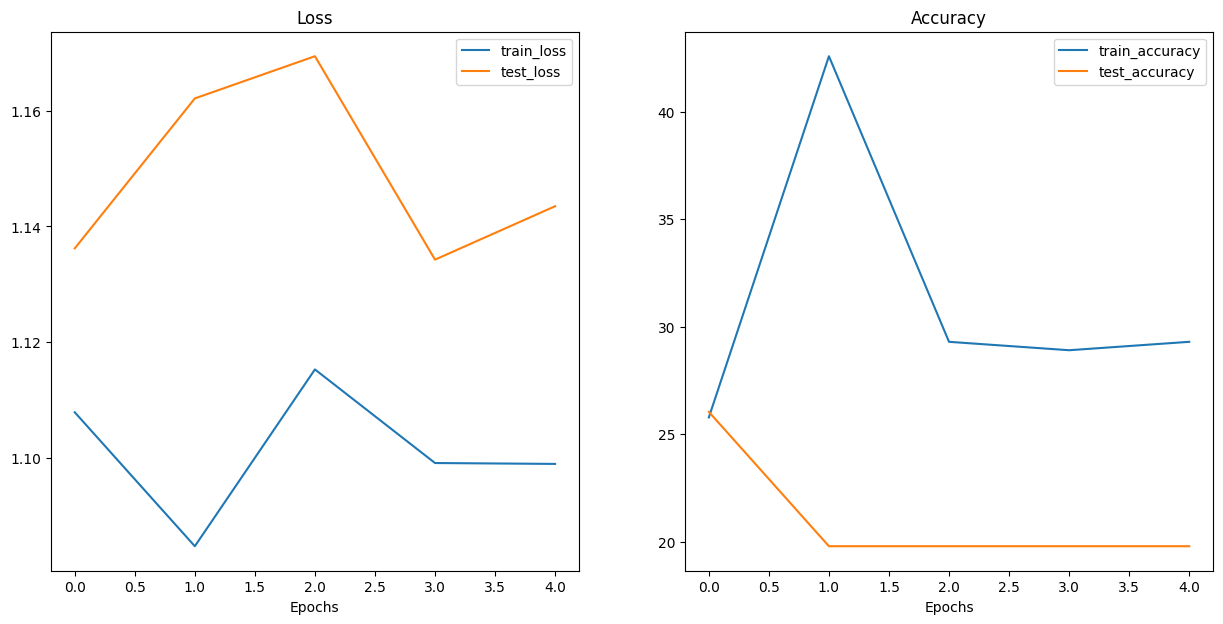

In [29]:
import matplotlib.pyplot as plt
plot_loss_curves(model_0_results);

In [30]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [31]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [33]:

# Try to make a prediction on image in uint8 format (this will error)
model_0.eval()
with torch.inference_mode():
    model_0(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [34]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

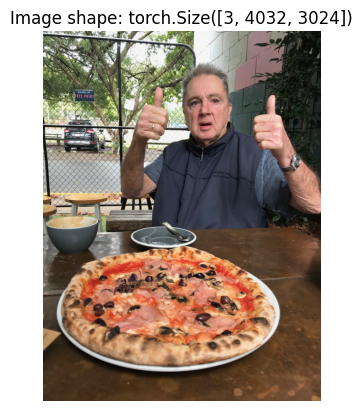

In [35]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [36]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [37]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

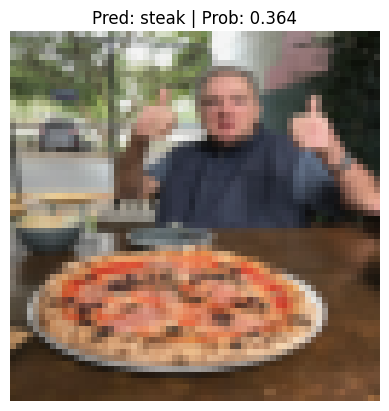

In [39]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)